#Carga de Datos

In [ ]:
!pip install geoplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 54.0 MB/s eta 0:00:00


In [ ]:
pip install jupyter-ai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


#Nsga2

In [ ]:
###################################################
#-----importing library---------------------------
###################################################
import pandas as pd
import numpy as np
import time
import copy
import random

In [ ]:
# prompt: poner una seed para el colab



np.random.seed(42)


In [ ]:
##################################################
#-----Initialization settings-----------------------
###################################################

#-----Genetic Algorithm Paramaters ----------------
population_size= 100
#population_size= 40
num_iteration=200
#num_iteration=200
crossover_rate= 0.8
mutation_rate= 0.3
mutation_selection_rate= 0.4


In [ ]:
metro = [0, 1, 2]  # Subway stations
paradas = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]  # Bus stops
autobuses = [0, 1, 2, 3, 4]  # Feeder routes
nodos = metro + paradas # Nodes (bus stops + subway stations)

In [ ]:
num_metro = len(metro)
num_paradas = len(paradas)
num_autobuses = len(autobuses)
num_nodos = len(nodos)

In [ ]:
# Define parameters
N_max = 5  # Maximum number of stations on each feeder route
Q = 50     # Maximum transport capacity per feeder bus route
c0 = 25    # Operating cost per unit distance
c1 = 26    # Cost coefficient for passenger travel

v_bus = 25  # Bus velocity
t_a = 7     # Transfer time bus-subway
t_b = 10    # Transfer time bus-bus

In [ ]:
###################################################
#-----Non-dominated sorting function---------------
###################################################

def non_dominated_sorting(population_size,chroms_obj_record):
    s,n={},{}
    front,rank={},{}
    front[0]=[]
    for p in range(population_size):
        s[p]=[]
        n[p]=0
        for q in range(population_size):

            if ((chroms_obj_record[p][0]>chroms_obj_record[q][0] and chroms_obj_record[p][1]<chroms_obj_record[q][1])
            or (chroms_obj_record[p][0]>=chroms_obj_record[q][0] and chroms_obj_record[p][1]<chroms_obj_record[q][1])
            or (chroms_obj_record[p][0]>chroms_obj_record[q][0] and chroms_obj_record[p][1]<=chroms_obj_record[q][1])):
                if q not in s[p]:
                    s[p].append(q)
            elif ((chroms_obj_record[p][0]<chroms_obj_record[q][0] and chroms_obj_record[p][1]>chroms_obj_record[q][1])
            or (chroms_obj_record[p][0]<=chroms_obj_record[q][0] and chroms_obj_record[p][1]>chroms_obj_record[q][1])
            or (chroms_obj_record[p][0]<chroms_obj_record[q][0] and chroms_obj_record[p][1]>=chroms_obj_record[q][1])):
                n[p]=n[p]+1
        if n[p]==0:
            rank[p]=0
            if p not in front[0]:
                front[0].append(p)

    i=0
    while (front[i]!=[]):
        Q=[]
        for p in front[i]:
            for q in s[p]:
                n[q]=n[q]-1
                if n[q]==0:
                    rank[q]=i+1
                    if q not in Q:
                        Q.append(q)
        i=i+1
        front[i]=Q

    del front[len(front)-1]
    return front

###################################################
#-----Calculate crowding distance function---------
###################################################

def calculate_crowding_distance(front,chroms_obj_record):

    distance={m:0 for m in front}
    for o in range(2):
        obj={m:chroms_obj_record[m][o] for m in front}
        sorted_keys=sorted(obj, key=obj.get)
        distance[sorted_keys[0]]=distance[sorted_keys[len(front)-1]]=999999999999
        for i in range(1,len(front)-1):
            if len(set(obj.values()))==1:
                distance[sorted_keys[i]]=distance[sorted_keys[i]]
            else:
                distance[sorted_keys[i]]=distance[sorted_keys[i]]+(obj[sorted_keys[i+1]]-obj[sorted_keys[i-1]])/(obj[sorted_keys[len(front)-1]]-obj[sorted_keys[0]])

    return distance

###################################################
#-----Selection------------------------------------
###################################################
def selection(population_size,front,chroms_obj_record,total_chromosome,total_tiempo,total_distancia_metro):

    N=0
    new_pop=[]
    while N < population_size:
        for i in range(len(front)):
            N=N+len(front[i])
            if N > population_size:
                distance=calculate_crowding_distance(front[i],chroms_obj_record)
                sorted_cdf=sorted(distance, key=distance.get)
                sorted_cdf.reverse()
                for j in sorted_cdf:
                    if len(new_pop)==population_size:
                        break
                    new_pop.append(j)
                break
            else:
                new_pop.extend(front[i])

    population_list,tiempo_nodos, distancia_metro,new_pop_obj = [], [], [], []
    for n in new_pop:
        population_list.append(total_chromosome[n])
        tiempo_nodos.append(total_tiempo[n])
        distancia_metro.append(total_distancia_metro[n])
        new_pop_obj.append(chroms_obj_record[n])

    return population_list,tiempo_nodos, distancia_metro,new_pop_obj,new_pop

###################################################
#-----Generate initial population------------------
###################################################

#Constrain 1: Toda ruta tiene que ir a almenos una estación de metro
#Constrain 2: Se tienen que ir a todas las estaciones "IMPORTANTES" de metro

def generar_lista_estacion(m, a): #m = metro, a = autobus
    # Aseguramos que todos los elementos de m aparezcan al menos una vez
    lista = list(np.random.choice(m, len(m), replace=False))  # Tomamos todos los valores de m al menos una vez (sin repetición)

    # Llenamos la lista con valores aleatorios adicionales hasta que tenga longitud n
    while len(lista) < a:
        lista.append(np.random.choice(m))

    np.random.shuffle(lista)  # Barajamos la lista para mantener el orden aleatorio
    return lista

def eliminar_repetidos_consecutivos(lista):
    if not lista:  # Si la lista está vacía, no hay nada que hacer
        return lista

    resultado = [lista[0]]  # Iniciamos el resultado con el primer elemento de la lista

    for i in range(1, len(lista)):
        if lista[i] != lista[i - 1]:  # Si el elemento actual no es igual al anterior
            resultado.append(lista[i])  # Lo agregamos al resultado

    return resultado


def objetivo_personas_0(total_chromosome,num_chromosoma):
  chromosoma = total_chromosome[num_chromosoma]
  objetivo_tiempo=0
  objetivo_personas=0
  demanda_copia = copy.deepcopy(demanda)
  for ruta in chromosoma:
    contador_tiempo = [0] * len(ruta)
    contador_personas_total = 0
    contador_personas_actual = 0
    for estacion in range(len(ruta)):
      if ruta[estacion] in metro:
        contador_personas_actual = 0

      if contador_personas_actual + demanda_copia[ruta[estacion]] <= Q:
        contador_personas_actual += demanda_copia[ruta[estacion]]
        contador_personas_total += demanda_copia[ruta[estacion]]
        demanda_copia[ruta[estacion]] = 0
      else:
        contador_personas_total += Q - contador_personas_actual
        demanda_copia[ruta[estacion]] -= Q - contador_personas_actual
        contador_personas_actual = Q

      for i in range(1,len(ruta)):
        if ruta[(estacion + i)%len(ruta)] in metro:
          contador_tiempo[estacion] += t_a + times[ruta[estacion]][ruta[(estacion + i)%len(ruta)]]
          if estacion != len(ruta) - 1:
            break
        else:
          contador_tiempo[estacion] += t_b + times[ruta[estacion]][ruta[(estacion + i)%len(ruta)]]
        if estacion == len(ruta) - 1:
          if ruta[(estacion + i)%len(ruta)] in metro:
            contador_personas_actual = 0

          if contador_personas_actual + demanda_copia[ruta[(estacion + i)%len(ruta)]] <= Q:
            contador_personas_actual += demanda_copia[ruta[(estacion + i)%len(ruta)]]
            contador_personas_total += demanda_copia[ruta[(estacion + i)%len(ruta)]]
            demanda_copia[ruta[(estacion + i)%len(ruta)]] = 0
          else:
            contador_personas_total += Q - contador_personas_actual
            demanda_copia[ruta[(estacion + i)%len(ruta)]] -= Q - contador_personas_actual
            contador_personas_actual = Q
    objetivo_personas += contador_personas_total*c1
  objetivo_tiempo += sum(contador_tiempo)+sum(demanda_copia)*600


  return objetivo_tiempo/60,objetivo_personas








###Objetivo

In [ ]:
# prompt: suma de lista de lista demanda

def suma_demanda_lista_listas(lista_listas):
  """
  Calcula la suma de los elementos en una lista de listas.

  Args:
    lista_listas: Una lista de listas de números.

  Returns:
    La suma de todos los elementos en la lista de listas.
  """
  suma_total = 0
  for lista in lista_listas:
    for elemento in lista:
      suma_total += elemento
  return suma_total



In [ ]:
def objetivo_personas(total_chromosome, total_tiempo_nodos,total_distancia_metro):
  objetivo_tiempo=0
  objetivo_personas=0
  demanda_copia = copy.deepcopy(demanda)


  for i in range(len(total_chromosome)):
    cromosoma = total_chromosome[i]
    tiempo_nodos = total_tiempo_nodos[i]
    distancia_metro = total_distancia_metro[i]
    contador_personas_actual = 0
    contador_personas_actual_nuevo = 0
    for j in range(len(cromosoma)):
      if cromosoma[j] == 0:
        contador_personas_actual = 0
        objetivo_personas += contador_personas_actual_nuevo - contador_personas_actual
      else:
        if j+distancia_metro[j]<len(tiempo_nodos):
          objetivo_tiempo += tiempo_nodos[j+distancia_metro[j]]-tiempo_nodos[j]
        else:
          objetivo_tiempo += tiempo_nodos[(j+distancia_metro[j])%len(tiempo_nodos)]-tiempo_nodos[j]+6
        # Ensure the hour index is within the valid range [0, 6]
        hora_index = math.floor(tiempo_nodos[j]/60)-6
        hora_index = max(0, min(6, hora_index))

        contador_personas_actual_nuevo = min(Q, contador_personas_actual + demanda_copia[hora_index][cromosoma[j]])
        demanda_copia[hora_index][cromosoma[j]] -= contador_personas_actual_nuevo - contador_personas_actual
        objetivo_personas += contador_personas_actual_nuevo - contador_personas_actual
        contador_personas_actual = contador_personas_actual_nuevo

  objetivo_tiempo += suma_demanda_lista_listas(demanda_copia)*600


  return objetivo_tiempo,objetivo_personas

In [ ]:
tiempo_duración = 6*60
hora_inicio = 6
import math

##Poblaciones

In [ ]:
def inicio_poblacion_9_0():
  population_list = []
  for i in range(population_size):
    ruteo = []
    lista_inicios = list(np.random.choice(nodos, num_autobuses, replace=False))
    for i in range(num_autobuses):
      autobus_ruta = []
      autobus_ruta.append(lista_inicios[i])
      #contador = 0
      tiempo = 0
      #personas = 0
      while tiempo < tiempo_duración:
        #agregar siguiente parada
        siguiente = random.choice(nodos)
        if siguiente == autobus_ruta[-1]:
          siguiente = random.choice(nodos)


        autobus_ruta.append(siguiente)
        tiempo += times[autobus_ruta[-2]][autobus_ruta[-1]]

      #print(heuristico_dt)
      ruteo.append(autobus_ruta)
    population_list.append(ruteo)
  return population_list


In [ ]:


def inicio_poblacion_9():
    population_list = []
    tiempo_nodos = []
    distancia_metro_total = []

    for _ in range(population_size):
        ruteo = []
        horas_ruteo = []
        distancia_metro = []

        lista_inicios = list(np.random.choice(nodos, num_autobuses, replace=False))
        for i in range(num_autobuses):
            autobus_ruta = [lista_inicios[i]]
            horas_autobus = [6]
            tiempo = 0
            contador_metro = 0

            if lista_inicios[i] in metro:
                distancia_metro_autobus = [0]
                contador_metro = 0
            else:
                distancia_metro_autobus = [1]
                contador_metro = 1

            while tiempo < tiempo_duración:
                siguiente = random.choice(nodos)
                if siguiente == autobus_ruta[-1]:
                    siguiente = random.choice(nodos)

                autobus_ruta.append(siguiente)
                tiempo += times[math.floor(tiempo/60)-6][autobus_ruta[-2]][autobus_ruta[-1]]
                hora = hora_inicio + tiempo / 60
                hora = max(6, min(hora, 12))
                horas_autobus.append(hora)

                if siguiente in metro:
                    contador_metro = 0
                    distancia_metro_autobus.append(0)
                else:
                    contador_metro += 1
                    distancia_metro_autobus.append(contador_metro)

            ruteo.append(autobus_ruta)
            horas_ruteo.append(horas_autobus)
            distancia_metro.append(distancia_metro_autobus)

        population_list.append(ruteo)
        tiempo_nodos.append(horas_ruteo)
        distancia_metro_total.append(distancia_metro)

    return population_list, tiempo_nodos, distancia_metro_total


In [ ]:

def inicio_poblacion_9_2(demanda):
  population_list = []
  total_tiempo_demanda = []
  tiempo_nodos = []
  distancia_metro_total = []
  copia_demanda = copy.deepcopy(demanda)
  for n in range(population_size):
    ruteo = []
    lista_inicios = list(np.random.choice(nodos, num_autobuses, replace=False))
    tiempo = [0]*num_autobuses
    personas = [0]*num_autobuses
    distancia_metro = []
    horas_ruteo = []
    contadores = [0]*num_autobuses
    for i in range(num_autobuses):
      autobus_ruta = []
      autobus_ruta.append(lista_inicios[i])
      autobus_tiempos = [6]
      if lista_inicios[i] in metro:
        autobus_metro = [0]
        contadores[i] = 0
      else:
        autobus_metro = [1]
        contadores[i] = 1
      #contador = 0
      ruteo.append(autobus_ruta)
      horas_ruteo.append(autobus_tiempos)
      distancia_metro.append(autobus_metro)

    while min(tiempo) < tiempo_duración:
      for i in range(num_autobuses):
        if tiempo[i] >= tiempo_duración:
          continue

        #agregar siguiente parada
        siguiente = random.choice(nodos)
        if siguiente == ruteo[i][-1] :
          siguiente =random.choice(nodos)

        distancia_metro[i].append(0)
        if siguiente in metro:
          personas[i] = 0
          for j in range(contadores[i]+1):
            distancia_metro[i][-(j+1)] = j
          contadores[i] = 0

        else:
          contadores[i] += 1


        if personas[i] + demanda[math.floor(horas_ruteo[i][-1]/60)-6][siguiente] < Q:
          personas[i] += demanda[math.floor(horas_ruteo[i][-1]/60)-6][siguiente]


        elif personas[i] + demanda[math.floor(horas_ruteo[i][-1]/60)-6][siguiente] == Q:
          personas[i] = Q

        else:
          siguiente = random.choice(metro)
          personas[i] = 0
          contadores[i] -= 1
          for j in range(contadores[i]):
            distancia_metro[i][-(j+1)] = j
          contadores[i] = 0



        ruteo[i].append(siguiente)


        tiempo[i] += times[math.floor(horas_ruteo[i][-1])-6][ruteo[i][-2]][ruteo[i][-1]]
        hora =  hora_inicio + tiempo[i]/60
        if hora > 12:
          hora = 12
        if hora < 6:
          hora = 6
        horas_ruteo[i].append(hora)

    population_list.append(ruteo)
    for i in range(num_autobuses):
      for j in range(contadores[i]):
        distancia_metro[i][-(j)] = j+distancia_metro[i][0]
    demanda = copy.deepcopy(copia_demanda)

    tiempo_nodos.append(horas_ruteo)
    distancia_metro_total.append(distancia_metro)
  return population_list, tiempo_nodos, distancia_metro_total


In [ ]:
def greedy_0(heuristico_dt):
  population_list = []
 #checar cosa
  heuristico_metro = heuristico_dt[:, metro]
  for i in range(population_size):
    ruteo = []
    heuristico_dt_c = copy.deepcopy(heuristico_dt)
    heuristico_metro_c = copy.deepcopy(heuristico_metro)
    lista_inicios = list(np.random.choice(nodos, num_autobuses, replace=False))
    tiempo = [0]*num_autobuses
    personas = [0]*num_autobuses
    for i in range(num_autobuses):
      autobus_ruta = []
      autobus_ruta.append(lista_inicios[i])
      #contador = 0
      ruteo.append(autobus_ruta)

    while min(tiempo) < 6*60:
      for i in range(num_autobuses):
        if tiempo[i] >= 6*60:
          continue

        #agregar siguiente parada
        siguiente = np.argmax(heuristico_dt_c[ruteo[i][-1]])
        if siguiente == ruteo[i][-1] :
          siguiente =random.choice(nodos)

        if personas[i] + demanda[siguiente] < Q:
          personas[i] += demanda[siguiente]
          heuristico_dt_c[:,siguiente] = 0

        elif personas[i] + demanda[siguiente] == Q:
          personas[i] = Q
          heuristico_dt_c[:,siguiente] = heuristico_dt_c[:,siguiente]*(1/2)
        else:
          siguiente = np.argmax(heuristico_metro_c[ruteo[i][-1]])
          heuristico_dt_c[:,siguiente] = heuristico_dt_c[:,siguiente]*(1/4)
          heuristico_metro_c[:,siguiente] = heuristico_metro_c[:,siguiente]*(1/4)
          personas[i] = 0



        ruteo[i].append(siguiente)
        tiempo[i] += times[ruteo[i][-2]][ruteo[i][-1]]

      #print(heuristico_dt)

    population_list.append(ruteo)
  return population_list


In [ ]:
def greedy(heuristico_dt):
    population_list = []
    tiempo_nodos = []
    distancia_metro_total = []

    heuristico_metro = heuristico_dt[:,:, metro]

    for n in range(population_size):
        ruteo = []
        heuristico_dt_c = copy.deepcopy(heuristico_dt)
        heuristico_metro_c = copy.deepcopy(heuristico_metro)
        lista_inicios = list(np.random.choice(nodos, num_autobuses, replace=False))
        tiempo = [0] * num_autobuses
        personas = [0] * num_autobuses
        distancia_metro = []
        horas_ruteo = []
        contadores = [0] * num_autobuses

        for i in range(num_autobuses):
            autobus_ruta = [lista_inicios[i]]
            ruteo.append(autobus_ruta)
            horas_ruteo.append([6])
            if lista_inicios[i] in metro:
                distancia_metro.append([0])
                contadores[i] = 0
            else:
                distancia_metro.append([1])
                contadores[i] = 1

        while min(tiempo) < 6*60:
            for i in range(num_autobuses):
                if tiempo[i] >= 6*60:
                    continue

                siguiente = np.argmax(heuristico_dt_c[math.floor(horas_ruteo[i][-1]/60)-6][ruteo[i][-1]])
                if siguiente == ruteo[i][-1]:
                    siguiente = random.choice(nodos)

                distancia_metro[i].append(0)
                if siguiente in metro:
                    personas[i] = 0
                    for j in range(contadores[i]):
                        distancia_metro[i][-(j+1)] = j
                    contadores[i] = 0
                else:
                    contadores[i] += 1

                if personas[i] + demanda[math.floor(horas_ruteo[i][-1]/60)-6][siguiente] < Q:
                    personas[i] += demanda[math.floor(horas_ruteo[i][-1]/60)-6][siguiente]
                    heuristico_dt_c[math.floor(horas_ruteo[i][-1]/60)-6][:, siguiente] = 0
                elif personas[i] + demanda[math.floor(horas_ruteo[i][-1]/60)-6][siguiente] == Q:
                    personas[i] = Q
                    heuristico_dt_c[math.floor(horas_ruteo[i][-1]/60)-6][:, siguiente] *= 0.5
                else:
                    siguiente = np.argmax(heuristico_metro_c[ruteo[i][-1]])
                    heuristico_dt_c[math.floor(horas_ruteo[i][-1]/60)-6][:, siguiente] *= 0.25
                    heuristico_metro_c[math.floor(horas_ruteo[i][-1]/60)-6][:, siguiente] *= 0.25
                    personas[i] = 0
                    contadores[i] -= 1
                    for j in range(contadores[i]):
                        distancia_metro[i][-(j+1)] = j
                    contadores[i] = 0

                ruteo[i].append(siguiente)
                tiempo[i] += times[math.floor(horas_ruteo[i][-1]/60)-6][ruteo[i][-2]][ruteo[i][-1]]
                hora = hora_inicio + tiempo[i] / 60
                hora = max(6, min(hora, 12))
                horas_ruteo[i].append(hora)

        population_list.append(ruteo)
        tiempo_nodos.append(horas_ruteo)
        distancia_metro_total.append(distancia_metro)

    return population_list, tiempo_nodos, distancia_metro_total

In [ ]:
def check_and_adjust_route_time(route, times):
  """
  Checks the total time of a route and removes nodes from the end
  until the total time is less than or equal to 540.

  Args:
    route: A list representing the nodes in the route.
    times: A 2D array representing the travel time between nodes.

  Returns:
    A list representing the adjusted route.
  """
  total_time = 0
  for s_route in route:
    for i in range(len(s_route) - 1):
      total_time += times[s_route[i]][s_route[i + 1]]

    while total_time > 540 and len(s_route) > 10:
      # Remove the last node
      total_time -= times[s_route[-2]][s_route[-1]]
      s_route.pop()

  return route

In [ ]:
def sumar_a_lista(lista,n):
  return [x + n for x in lista]

In [ ]:
def check_and_adjust(times, p1_ruta, p1_corte, p1_tiempoNodos,p1_distanciaMetro,
                     p2_ruta, p2_corte, p2_tiempoNodos,p2_distanciaMetro ):
  child = p1_ruta[:p1_corte] + p2_ruta[p2_corte:]
  tiempo_cambio = (p1_tiempoNodos[p1_corte-1] + times[math.floor(p1_tiempoNodos[p1_corte-1]/60-6)][p1_ruta[p1_corte-1]][p2_ruta[p2_corte]])/60
  child_tiempoNodos = p1_tiempoNodos[:p1_corte] + [tiempo_cambio] + sumar_a_lista(p2_tiempoNodos[p2_corte+1:],(tiempo_cambio)-p2_tiempoNodos[p2_corte])
  child_distanciaMetro = p1_distanciaMetro[:p1_corte] + p2_distanciaMetro[p2_corte:]

  return child, child_tiempoNodos, child_distanciaMetro


In [ ]:
def mutacion_check_adjust(times, index1,chromosome,tiempoNodos,distanciaMetro ):
      # Invertir el segmento seleccionado en la ruta

    contador = 0

    def elegir_nuevo():
      if chromosome[index1] in metro:
        return  random.choice(metro)
      else:
        return random.choice(paradas)
    chromosome_cambio = elegir_nuevo()

    while chromosome_cambio == chromosome[index1] or contador<20:
      chromosome_cambio = elegir_nuevo()
      contador += 1
    if contador > 20:
      return chromosome,tiempoNodos,distanciaMetro
    child, child_tiempoNodos,child_distanciaMetro = [],[],[]

    tiempo_cambio_1 = (tiempoNodos[index1-1]*60 + times[math.floor(tiempoNodos[index1-1]/60-6)][chromosome[index1-1]][chromosome_cambio])/60
    contador2 = 0
    # FIX: Changed OR to AND in the while condition
    while (math.floor(tiempo_cambio_1)-6 > 6) and (contador2 < 20):
      chromosome_cambio = elegir_nuevo()
      contador2 += 1
      tiempo_cambio_1 = (tiempoNodos[index1-1]*60 + times[math.floor(tiempoNodos[index1-1]/60-6)][chromosome[index1-1]][chromosome_cambio])/60
    if contador2 >= 20:  # Changed to >= for consistency
      return chromosome,tiempoNodos,distanciaMetro
    tiempo_cambio_2 = (tiempo_cambio_1*60 + times[math.floor(tiempo_cambio_1/60)-6][chromosome_cambio][chromosome[index1+1]])/60
    #print(tiempo_cambio_2)
    child = chromosome[:index1] + [chromosome_cambio] + chromosome[index1+1:]

    child_tiempoNodos = tiempoNodos[:index1] + [tiempo_cambio_1,tiempo_cambio_2] + sumar_a_lista(tiempoNodos[index1+2:],(tiempo_cambio_2)-tiempoNodos[index1+1])

    child_distanciaMetro = distanciaMetro

    return child, child_tiempoNodos, child_distanciaMetro

##Todo


In [ ]:
###################################################
#-----Main-----------------------------------------
###################################################

###################################################
#-----Generate initial population------------------
###################################################

def todo_9_2():
  demanda = resultados_por_hora
  start_time = time.time()
  best_obj_hist_T = []
  best_obj_hist_P = []
  start_time = time.time()
  best_list,best_obj=[],[]
  population_list=[]
  total_tiempo_demanda, tiempo_nodos, distancia_metro = [], [], []
  population_list,tiempo_nodos, distancia_metro = inicio_poblacion_9_2(demanda)
  print(population_list)
  population_size = len(population_list)
  for n in range(num_iteration):
      ###################################################
      #-----Crossover------------------------------------
      ###################################################
      parent_list=copy.deepcopy(population_list)
      parent_tiempo_nodos=copy.deepcopy(tiempo_nodos)
      parent_distancia_metro=copy.deepcopy(distancia_metro)


      offspring_list=[]
      offspring_tiempo_nodos, offspring_distancia_metro = [], []
      S=list(np.random.permutation(population_size)) # generate a random sequence to select the parent chromosome to crossover

      for m in range(int(population_size/2)):
          cross_prob=np.random.rand()
          if crossover_rate >= cross_prob:
            parent_1= population_list[S[2*m]][:]
            parent_2= population_list[S[2*m+1]][:]

            parent_1_tiempo_nodos= tiempo_nodos[S[2*m]][:]
            parent_2_tiempo_nodos= tiempo_nodos[S[2*m+1]][:]

            parent_1_distancia_metro= distancia_metro[S[2*m]][:]
            parent_2_distancia_metro= distancia_metro[S[2*m+1]][:]



            child_1=parent_1[:]
            child_2=parent_2[:]
            child_1_tiempo_nodos=parent_1_tiempo_nodos[:]
            child_2_tiempo_nodos=parent_2_tiempo_nodos[:]
            child_1_distancia_metro=parent_1_distancia_metro[:]
            child_2_distancia_metro=parent_2_distancia_metro[:]

            for auto in range(num_autobuses):
              counter_metro_1 = 0
              counter_metro_2 = 0
              lugar = 0
              pos_p1 = 0
              pos_p2 = 0
              if len(parent_1[auto]) > 2 and len(parent_2[auto]) > 2:
                while lugar < len(parent_1[auto]) or lugar < len(parent_2[auto]):
                  if lugar < len(parent_1[auto]):
                    if parent_1[auto][lugar] in metro:
                      counter_metro_1 = 1
                      pos_p1 = lugar
                  if lugar < len(parent_2[auto]):
                    if parent_2[auto][lugar] in metro:
                      counter_metro_2 = 1
                      pos_p2 = lugar
                  if counter_metro_1 + counter_metro_2 == 2:
                    break
                  lugar += 1


                child_1[auto],child_1_tiempo_nodos[auto],child_1_distancia_metro[auto] = check_and_adjust(times,
                      parent_1[auto], pos_p1, parent_1_tiempo_nodos[auto],parent_1_distancia_metro[auto],
                      parent_2[auto], pos_p2, parent_2_tiempo_nodos[auto],parent_2_distancia_metro[auto] )

                child_2[auto],child_2_tiempo_nodos[auto],child_2_distancia_metro[auto] = check_and_adjust(times,
                      parent_2[auto], pos_p2, parent_2_tiempo_nodos[auto],parent_2_distancia_metro[auto],
                      parent_1[auto], pos_p1, parent_1_tiempo_nodos[auto],parent_1_distancia_metro[auto] )



            offspring_list.extend([child_1,child_2])
            offspring_tiempo_nodos.extend([child_1_tiempo_nodos,child_2_tiempo_nodos])
            offspring_distancia_metro.extend([child_1_distancia_metro,child_2_distancia_metro])

      ###################################################
      #-----Mutation-------------------------------------
      ###################################################
      for m in range(len(offspring_list)):
          mutation_prob=np.random.rand()
          if mutation_rate <= mutation_prob:
            for auto in range(num_autobuses):
              mutation_selection_prob=np.random.rand()
              if mutation_selection_rate <= mutation_selection_prob:
                  chromosome=offspring_list[m][auto]
                  tiempoNodos=offspring_tiempo_nodos[m][auto]
                  distanciaMetro=offspring_distancia_metro[m][auto]
                  if len(chromosome)>2:

                    index1 = np.random.randint(1,len(chromosome)-1)

                    offspring_list[m][auto],offspring_tiempo_nodos[m][auto],offspring_distancia_metro[m][auto] = mutacion_check_adjust(times, index1,chromosome,tiempoNodos,distanciaMetro )


      ###################################################
      #-----Fitness valuse ------------------------------
      ###################################################
      total_chromosome=copy.deepcopy(parent_list)+copy.deepcopy(offspring_list)
      total_tiempo_nodos=copy.deepcopy(parent_tiempo_nodos)+copy.deepcopy(offspring_tiempo_nodos)
      total_distancia_metro=copy.deepcopy(parent_distancia_metro)+copy.deepcopy(offspring_distancia_metro)

      chroms_obj_record={}
      for m in range(len(total_chromosome)):

          obj_tiempo,obj_personas = objetivo_personas(total_chromosome[m], total_tiempo_nodos[m],total_distancia_metro[m])
          chroms_obj_record[m]=[obj_personas,obj_tiempo]

      ###################################################
      #-----Non-dominated sorting -----------------------
      ###################################################
      front=non_dominated_sorting(len(total_chromosome),chroms_obj_record)

      ###################################################
      #-----Selection -----------------------------------
      ###################################################
      population_list,tiempo_nodos, distancia_metro,new_pop_obj,new_pop=selection(population_size,front,chroms_obj_record,total_chromosome,total_tiempo_nodos,total_distancia_metro)


      ###################################################
      #-----Comparison ----------------------------------
      ###################################################
      if n==0:
          best_list=copy.deepcopy(population_list)
          best_obj=copy.deepcopy(new_pop_obj)
          best_list_tiempo_nodos=copy.deepcopy(tiempo_nodos)
          best_list_distancia_metro=copy.deepcopy(distancia_metro)
      else:
          total_list=copy.deepcopy(population_list)+copy.deepcopy(best_list)
          total_obj=copy.deepcopy(new_pop_obj)+copy.deepcopy(best_obj)
          total_list_tiempo_nodos=copy.deepcopy(tiempo_nodos)+copy.deepcopy(best_list_tiempo_nodos)
          total_list_distancia_metro=copy.deepcopy(distancia_metro)+copy.deepcopy(best_list_distancia_metro)

          now_best_front=non_dominated_sorting(population_size,total_obj)
          best_list,best_list_tiempo_nodos,best_list_distancia_metro,best_obj,best_pop=selection(population_size,now_best_front,total_obj,total_list,total_list_tiempo_nodos,total_list_distancia_metro)

          best_obj_hist_T.append(best_obj[0][1])
          best_obj_hist_P.append(best_obj[0][0])
          print('-----Results -----------------------------')
          print("One chromosome=",best_list[0])
          print("[Tiempo,Personas]=",best_obj[0])
          print(n,'th iteration')
          print('------------------------------------------')
  ###################################################
  #-----Results ------------------------------------
  ###################################################
  print('-----Results -----------------------------')
  print("One chromosome=",best_list[0])
  print("[Tiempo,Personas]=",best_obj[0])
  print("------------------------------------------")
  print('The elapsed time:%s'% (time.time() - start_time))

  plt.plot(best_obj_hist_T)
  plt.xlabel("Generations")
  plt.ylabel("Best Objective (Tiempo)")
  plt.title("Improvement of Generations")
  plt.show()

  plt.plot(best_obj_hist_P)
  plt.xlabel("Generations")
  plt.ylabel("Best Objective (Personas)")
  plt.title("Improvement of Generations")
  plt.show()
  a = np.array(best_obj)
  plt.figure(figsize=(8,6))
  plt.xlabel('Personas', fontsize=15)
  plt.ylabel('Tiempo', fontsize=15)
  plt.title("Pareto optimal")
  #plt.scatter(b[:,0], b[:,1], s=15)
  plt.scatter(a[:,0], a[:,1], c='blue', s=15)
  plt.scatter(best_obj_hist_P,best_obj_hist_T, c='red', s=15)
  plt.show()

  return best_list,best_obj

In [ ]:
def todo_9():
  start_time = time.time()
  best_obj_hist_T = []
  best_obj_hist_P = []
  start_time = time.time()
  best_list,best_obj=[],[]
  population_list=[]
  total_tiempo_demanda, tiempo_nodos, distancia_metro = [], [], []
  population_list,tiempo_nodos, distancia_metro = inicio_poblacion_9()

  for n in range(num_iteration):
      ###################################################
      #-----Crossover------------------------------------
      ###################################################
      parent_list=copy.deepcopy(population_list)
      parent_tiempo_nodos=copy.deepcopy(tiempo_nodos)
      parent_distancia_metro=copy.deepcopy(distancia_metro)


      offspring_list=[]
      offspring_tiempo_nodos, offspring_distancia_metro = [], []
      S=list(np.random.permutation(population_size)) # generate a random sequence to select the parent chromosome to crossover

      for m in range(int(population_size/2)):
          cross_prob=np.random.rand()
          if crossover_rate >= cross_prob:
            parent_1= population_list[S[2*m]][:]
            parent_2= population_list[S[2*m+1]][:]

            parent_1_tiempo_nodos= tiempo_nodos[S[2*m]][:]
            parent_2_tiempo_nodos= tiempo_nodos[S[2*m+1]][:]

            parent_1_distancia_metro= distancia_metro[S[2*m]][:]
            parent_2_distancia_metro= distancia_metro[S[2*m+1]][:]



            child_1=parent_1[:]
            child_2=parent_2[:]
            child_1_tiempo_nodos=parent_1_tiempo_nodos[:]
            child_2_tiempo_nodos=parent_2_tiempo_nodos[:]
            child_1_distancia_metro=parent_1_distancia_metro[:]
            child_2_distancia_metro=parent_2_distancia_metro[:]

            for auto in range(num_autobuses):
              counter_metro_1 = 0
              counter_metro_2 = 0
              lugar = 0
              pos_p1 = 0
              pos_p2 = 0
              while lugar < len(parent_1[auto]) or lugar < len(parent_2[auto]):
                if lugar < len(parent_1[auto]):
                  if parent_1[auto][lugar] in metro:
                    counter_metro_1 = 1
                    pos_p1 = lugar
                if lugar < len(parent_2[auto]):
                  if parent_2[auto][lugar] in metro:
                    counter_metro_2 = 1
                    pos_p2 = lugar
                if counter_metro_1 + counter_metro_2 == 2:
                  break
                lugar += 1


              child_1[auto],child_1_tiempo_nodos[auto],child_1_distancia_metro[auto] = check_and_adjust(times,
                     parent_1[auto], pos_p1, parent_1_tiempo_nodos[auto],parent_1_distancia_metro[auto],
                     parent_2[auto], pos_p2, parent_2_tiempo_nodos[auto],parent_2_distancia_metro[auto] )

              child_2[auto],child_2_tiempo_nodos[auto],child_2_distancia_metro[auto] = check_and_adjust(times,
                     parent_2[auto], pos_p2, parent_2_tiempo_nodos[auto],parent_2_distancia_metro[auto],
                     parent_1[auto], pos_p1, parent_1_tiempo_nodos[auto],parent_1_distancia_metro[auto] )



            offspring_list.extend(child_1,child_2)
            offspring_tiempo_nodos.extend(child_1_tiempo_nodos,child_2_tiempo_nodos)
            offspring_distancia_metro.extend(child_1_distancia_metro,child_2_distancia_metro)

      ###################################################
      #-----Mutation-------------------------------------
      ###################################################
      for m in range(len(offspring_list)):
          mutation_prob=np.random.rand()
          if mutation_rate <= mutation_prob:
            for auto in range(num_autobuses):
              mutation_selection_prob=np.random.rand()
              if mutation_selection_rate <= mutation_selection_prob:
                  chromosome=offspring_list[m][auto]
                  tiempoNodos=offspring_tiempo_nodos[m][auto]
                  distanciaMetro=offspring_distancia_metro[m][auto]
                  index1 = np.random.randint(0,len(chromosome))

                  offspring_list[m][auto],offspring_tiempo_nodos[m][auto],offspring_distancia_metro[m][auto] = mutacion_check_adjust(times,chromosome,tiempoNodos,distanciaMetro,m )


      ###################################################
      #-----Fitness valuse ------------------------------
      ###################################################
      total_chromosome=copy.deepcopy(parent_list)+copy.deepcopy(offspring_list)
      total_tiempo_nodos=copy.deepcopy(parent_tiempo_nodos)+copy.deepcopy(offspring_tiempo_nodos)
      total_distancia_metro=copy.deepcopy(parent_distancia_metro)+copy.deepcopy(offspring_distancia_metro)

      chroms_obj_record={}
      for m in range(len(total_chromosome)):

          obj_tiempo,obj_personas = objetivo_personas(total_chromosome[m], total_tiempo_nodos[m],total_distancia_metro[m])
          chroms_obj_record[m]=[obj_personas,obj_tiempo]

      ###################################################
      #-----Non-dominated sorting -----------------------
      ###################################################
      front=non_dominated_sorting(len(total_chromosome),chroms_obj_record)

      ###################################################
      #-----Selection -----------------------------------
      ###################################################
      population_list,tiempo_nodos, distancia_metro,new_pop_obj,new_pop=selection(population_size,front,chroms_obj_record,total_chromosome,total_tiempo_nodos,total_distancia_metro)


      ###################################################
      #-----Comparison ----------------------------------
      ###################################################
      if n==0:
          best_list=copy.deepcopy(population_list)
          best_obj=copy.deepcopy(new_pop_obj)
      else:
          total_list=copy.deepcopy(population_list)+copy.deepcopy(best_list)
          total_obj=copy.deepcopy(new_pop_obj)+copy.deepcopy(best_obj)

          now_best_front=non_dominated_sorting(population_size,total_obj)
          best_list,best_pop=selection(population_size,now_best_front,total_obj,total_list)
          best_obj=[total_obj[k] for k in best_pop]
          best_obj_hist_T.append(best_obj[0][1])
          best_obj_hist_P.append(best_obj[0][0])
          print('-----Results -----------------------------')
          print("One chromosome=",best_list[0])
          print("[Tiempo,Personas]=",best_obj[0])
          print(n,'th iteration')
          print('------------------------------------------')
  ###################################################
  #-----Results ------------------------------------
  ###################################################
  print('-----Results -----------------------------')
  print("One chromosome=",best_list[0])
  print("[Tiempo,Personas]=",best_obj[0])
  print("------------------------------------------")
  print('The elapsed time:%s'% (time.time() - start_time))

  plt.plot(best_obj_hist_T)
  plt.xlabel("Generations")
  plt.ylabel("Best Objective (Tiempo)")
  plt.title("Improvement of Generations")
  plt.show()

  plt.plot(best_obj_hist_P)
  plt.xlabel("Generations")
  plt.ylabel("Best Objective (Personas)")
  plt.title("Improvement of Generations")
  plt.show()
  a = np.array(best_obj)
  plt.figure(figsize=(8,6))
  plt.xlabel('Personas', fontsize=15)
  plt.ylabel('Tiempo', fontsize=15)
  plt.title("Pareto optimal")
  #plt.scatter(b[:,0], b[:,1], s=15)
  plt.scatter(a[:,0], a[:,1], c='blue', s=15)
  plt.scatter(best_obj_hist_P,best_obj_hist_T, c='red', s=15)
  plt.show()

  return best_list,best_obj

In [ ]:
###################################################
#-----Main-----------------------------------------
###################################################

###################################################
#-----Generate initial population------------------
###################################################

def todo2():
  start_time = time.time()
  best_obj_hist_T = []
  best_obj_hist_P = []
  start_time = time.time()
  best_list,best_obj=[],[]
  population_list=[]
  total_tiempo_demanda, tiempo_nodos, distancia_metro = [], [], []
  population_list,tiempo_nodos, distancia_metro = greedy(heuristico_dt)

  for n in range(num_iteration):
    ###################################################
    #-----Crossover------------------------------------
    ###################################################
    parent_list=copy.deepcopy(population_list)
    parent_tiempo_nodos=copy.deepcopy(tiempo_nodos)
    parent_distancia_metro=copy.deepcopy(distancia_metro)


    offspring_list=[]
    offspring_tiempo_nodos, offspring_distancia_metro = [], []
    S=list(np.random.permutation(population_size)) # generate a random sequence to select the parent chromosome to crossover

    for m in range(int(population_size/2)):
        cross_prob=np.random.rand()
        if crossover_rate >= cross_prob:
          parent_1= population_list[S[2*m]][:]
          parent_2= population_list[S[2*m+1]][:]

          parent_1_tiempo_nodos= tiempo_nodos[S[2*m]][:]
          parent_2_tiempo_nodos= tiempo_nodos[S[2*m+1]][:]

          parent_1_distancia_metro= distancia_metro[S[2*m]][:]
          parent_2_distancia_metro= distancia_metro[S[2*m+1]][:]



          child_1=parent_1[:]
          child_2=parent_2[:]
          child_1_tiempo_nodos=parent_1_tiempo_nodos[:]
          child_2_tiempo_nodos=parent_2_tiempo_nodos[:]
          child_1_distancia_metro=parent_1_distancia_metro[:]
          child_2_distancia_metro=parent_2_distancia_metro[:]

          for auto in range(num_autobuses):
            counter_metro_1 = 0
            counter_metro_2 = 0
            lugar = 0
            pos_p1 = 0
            pos_p2 = 0
            while lugar < len(parent_1[auto]) or lugar < len(parent_2[auto]):
              if lugar < len(parent_1[auto]):
                if parent_1[auto][lugar] in metro:
                  counter_metro_1 = 1
                  pos_p1 = lugar
              if lugar < len(parent_2[auto]):
                if parent_2[auto][lugar] in metro:
                  counter_metro_2 = 1
                  pos_p2 = lugar
              if counter_metro_1 + counter_metro_2 == 2:
                break
              lugar += 1


            child_1[auto],child_1_tiempo_nodos[auto],child_1_distancia_metro[auto] = check_and_adjust(times,
                    parent_1[auto], pos_p1, parent_1_tiempo_nodos[auto],parent_1_distancia_metro[auto],
                    parent_2[auto], pos_p2, parent_2_tiempo_nodos[auto],parent_2_distancia_metro[auto] )

            child_2[auto],child_2_tiempo_nodos[auto],child_2_distancia_metro[auto] = check_and_adjust(times,
                    parent_2[auto], pos_p2, parent_2_tiempo_nodos[auto],parent_2_distancia_metro[auto],
                    parent_1[auto], pos_p1, parent_1_tiempo_nodos[auto],parent_1_distancia_metro[auto] )



          offspring_list.extend(child_1,child_2)
          offspring_tiempo_nodos.extend(child_1_tiempo_nodos,child_2_tiempo_nodos)
          offspring_distancia_metro.extend(child_1_distancia_metro,child_2_distancia_metro)

    ###################################################
    #-----Mutation-------------------------------------
    ###################################################
    for m in range(len(offspring_list)):
        mutation_prob=np.random.rand()
        if mutation_rate <= mutation_prob:
          for auto in range(num_autobuses):
            mutation_selection_prob=np.random.rand()
            if mutation_selection_rate <= mutation_selection_prob:
                chromosome=offspring_list[m][auto]
                tiempoNodos=offspring_tiempo_nodos[m][auto]
                distanciaMetro=offspring_distancia_metro[m][auto]
                index1 = np.random.randint(0,len(chromosome))

                offspring_list[m][auto],offspring_tiempo_nodos[m][auto],offspring_distancia_metro[m][auto] = mutacion_check_adjust(times,chromosome,tiempoNodos,distanciaMetro,m )


    ###################################################
    #-----Fitness valuse ------------------------------
    ###################################################
    total_chromosome=copy.deepcopy(parent_list)+copy.deepcopy(offspring_list)
    total_tiempo_nodos=copy.deepcopy(parent_tiempo_nodos)+copy.deepcopy(offspring_tiempo_nodos)
    total_distancia_metro=copy.deepcopy(parent_distancia_metro)+copy.deepcopy(offspring_distancia_metro)

    chroms_obj_record={}
    for m in range(len(total_chromosome)):

        obj_tiempo,obj_personas = objetivo_personas(total_chromosome[m], total_tiempo_nodos[m],total_distancia_metro[m])
        chroms_obj_record[m]=[obj_personas,obj_tiempo]

    ###################################################
    #-----Non-dominated sorting -----------------------
    ###################################################
    front=non_dominated_sorting(len(total_chromosome),chroms_obj_record)

    ###################################################
    #-----Selection -----------------------------------
    ###################################################
    population_list,tiempo_nodos, distancia_metro,new_pop_obj,new_pop=selection(population_size,front,chroms_obj_record,total_chromosome,total_tiempo_nodos,total_distancia_metro)


    ###################################################
    #-----Comparison ----------------------------------
    ###################################################
    if n==0:
        best_list=copy.deepcopy(population_list)
        best_obj=copy.deepcopy(new_pop_obj)
    else:
        total_list=copy.deepcopy(population_list)+copy.deepcopy(best_list)
        total_obj=copy.deepcopy(new_pop_obj)+copy.deepcopy(best_obj)

        now_best_front=non_dominated_sorting(population_size,total_obj)
        best_list,best_pop=selection(population_size,now_best_front,total_obj,total_list)
        best_obj=[total_obj[k] for k in best_pop]
        best_obj_hist_T.append(best_obj[0][1])
        best_obj_hist_P.append(best_obj[0][0])
        print('-----Results -----------------------------')
        print("One chromosome=",best_list[0])
        print("[Tiempo,Personas]=",best_obj[0])
        print(n,'th iteration')
        print('------------------------------------------')
###################################################
#-----Results ------------------------------------
###################################################
  print('-----Results -----------------------------')
  print("One chromosome=",best_list[0])
  print("[Tiempo,Personas]=",best_obj[0])
  print("------------------------------------------")
  print('The elapsed time:%s'% (time.time() - start_time))

  plt.plot(best_obj_hist_T)
  plt.xlabel("Generations")
  plt.ylabel("Best Objective (Tiempo)")
  plt.title("Improvement of Generations")
  plt.show()

  plt.plot(best_obj_hist_P)
  plt.xlabel("Generations")
  plt.ylabel("Best Objective (Personas)")
  plt.title("Improvement of Generations")
  plt.show()
  a = np.array(best_obj)
  plt.figure(figsize=(8,6))
  plt.xlabel('Personas', fontsize=15)
  plt.ylabel('Tiempo', fontsize=15)
  plt.title("Pareto optimal")
  #plt.scatter(b[:,0], b[:,1], s=15)
  plt.scatter(a[:,0], a[:,1], c='blue', s=15)
  plt.scatter(best_obj_hist_P,best_obj_hist_T, c='red', s=15)
  plt.show()

  return best_list,best_obj

#Prueba monterrey

Solo tomar la mañana

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Procesar Demanda

In [ ]:
# prompt: cargar el archivo DatosFiltrados.geojson usando geopandas

import pandas as pd
import geopandas as gpd

# Reemplaza 'ruta_al_archivo.geojson' con la ruta real a tu archivo
gdf = gpd.read_file('DatosFiltrados.geojson')
gdf = gdf.to_crs(epsg=4326)




In [ ]:
gdf = gdf[gdf.HoraOri.dt.hour<= 11]

In [ ]:
copia_gdf = gdf.copy()
gdf_ordenada = gdf.sort_values(by=['coord_origen'])



In [ ]:
# prompt: cargar el archivo Centroides.geojson

import pandas as pd
gdf_centroides = gpd.read_file('Centroides.geojson')
gdf_centroides = gdf_centroides.to_crs(epsg=4326)



In [ ]:
# prompt: sublista tomando solo los agebs que esten en la lista sublista.AGEB.unique()

agebs_unicos = gdf_ordenada.AGEB.unique()
sublista_filtrada = gdf_centroides[gdf_centroides.AGEB.isin(agebs_unicos)]


In [ ]:
# prompt: agregar una columna a sublista_filtrada que se llame "suma" y que cuente cuantas veces ese valor de ageb se repite en la lista sublista

# Crear una serie que cuente las ocurrencias de cada valor de AGEB en sublista
ageb_counts = gdf_ordenada.AGEB.value_counts()

# Agregar la columna "suma" a sublista_filtrada usando la serie de conteos
sublista_filtrada['suma'] = sublista_filtrada.AGEB.map(ageb_counts)


/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


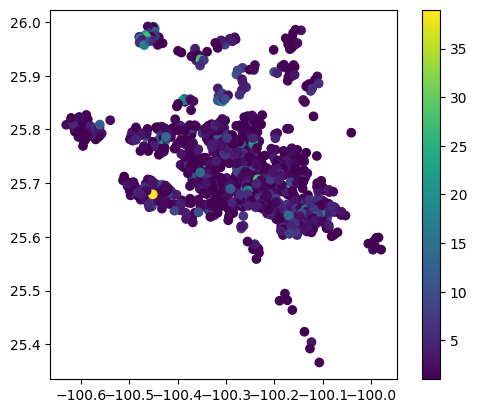

In [ ]:
# prompt: plotea con geopandas sublista_filtrada

import matplotlib.pyplot as plt

# Plotea el GeoDataFrame con la columna 'suma' como valores de color
sublista_filtrada.plot(column='suma', legend=True)
plt.show()


##Cargar Estaciones

In [ ]:
# prompt: cargar archivo estaciones.json

import json

with open('estaciones.json', 'r') as f:
  estaciones = json.load(f)



In [ ]:
estaciones['features'][1]

{'type': 'Feature',
 'properties': {'fid': 2, 'tipo': 'Metro Linea 1', 'nombre': 'San Bernabé'},
 'geometry': {'type': 'Point', 'coordinates': [-100.36175019, 25.74854753]},
 'id': 'estaciones_metro_ecovia.2'}

In [ ]:
# prompt: hacer un dataframe con las "coordinates" y "id" de cada valor de estaciones

import pandas as pd

# Crear una lista para almacenar los datos de las estaciones
estaciones_data = []

# Iterar sobre los datos de las estaciones
for estacion in estaciones["features"]:
  estaciones_data.append({
      'id': estacion['id'],
      'geometry': estacion['geometry'],
      "coordenadas": estacion['geometry']['coordinates']
  })

# Crear un DataFrame a partir de la lista de datos
df_estaciones = pd.DataFrame(estaciones_data)



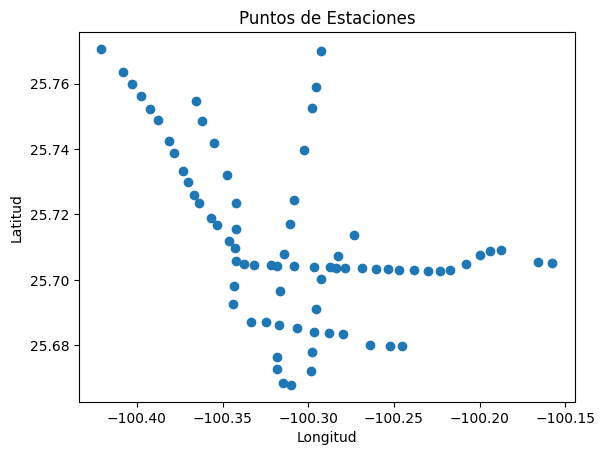

In [ ]:
# prompt: plot los puntos de df_estaciones

import matplotlib.pyplot as plt

# Extraer las coordenadas x e y del DataFrame
x_coords = [coord[0] for coord in df_estaciones['coordenadas']]
y_coords = [coord[1] for coord in df_estaciones['coordenadas']]

# Crear el gráfico de dispersión
plt.scatter(x_coords, y_coords)

# Agregar etiquetas a los ejes
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Agregar un título al gráfico
plt.title('Puntos de Estaciones')

# Mostrar el gráfico
plt.show()


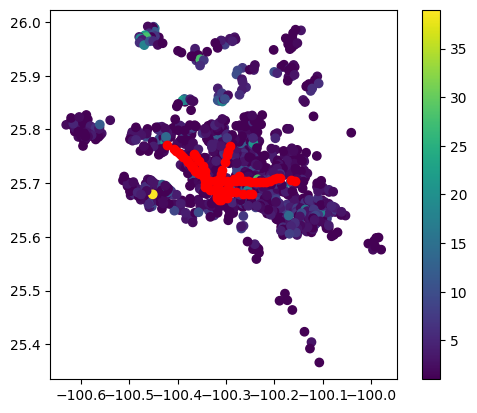

In [ ]:
# prompt: agrega los dos puntos generados al plot anterior

import matplotlib.pyplot as plt

# Plotea el GeoDataFrame con la columna 'suma' como valores de color
ax = sublista_filtrada.plot(column='suma', legend=True)

# Agrega los dos puntos generados al plot
ax.scatter(x_coords, y_coords, color='red')

plt.show()


In [ ]:
# prompt: del dataset sublista separa la variable coord_centroide y haz dos columnas nuevas que sea coordenada x y coordenada y

import pandas as pd
# Crear dos nuevas columnas 'coord_x' y 'coord_y'
sublista_filtrada[['coord_x']] = sublista_filtrada['geometry'].x.apply(pd.Series)
sublista_filtrada[['coord_y']] = sublista_filtrada['geometry'].y.apply(pd.Series)
# Eliminar la columna 'coord_centroide' si ya no es necesaria
#sublista_filtrada = sublista_filtrada.drop('coord_centroide', axis=1)




/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


##Reducir el Problema

In [ ]:

valores_a_eliminar = ['A/B', 'C+','N/D']
sublista_filtrada_socio = sublista_filtrada[~sublista_filtrada['NIVEL'].isin(valores_a_eliminar)]


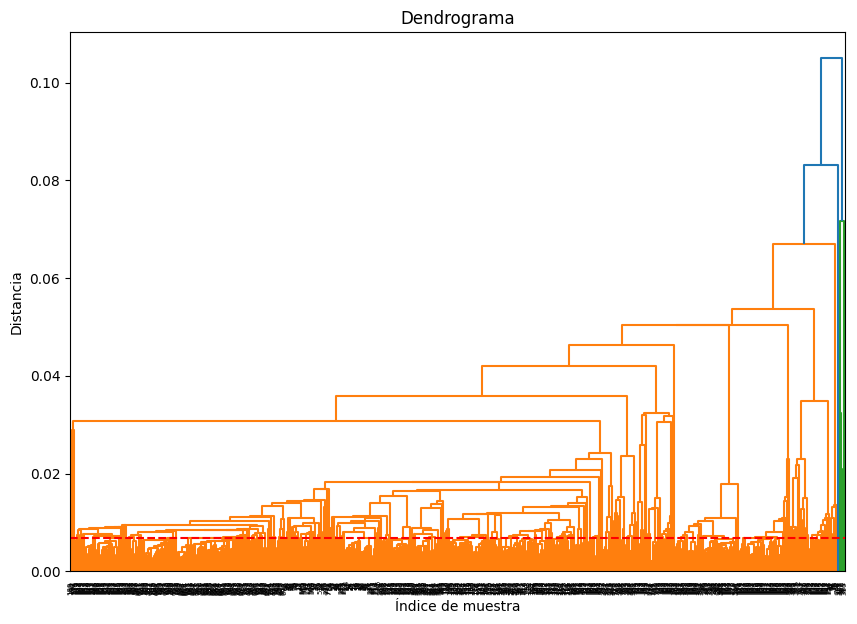

248


In [ ]:
# prompt: haz un kmeans de dos dimensiones con el dataset sublista_filtrada

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np
# Selecciona las columnas de coordenadas para el clustering
X = sublista_filtrada_socio[['coord_x','coord_y']]

# Calcular el enlace
linked = linkage(X, 'single')

# Crear el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', labels=np.arange(1, len(X)+1), distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrograma')
plt.xlabel('Índice de muestra')
plt.ylabel('Distancia')
distancia_corte = 0.006835
plt.axhline(y=distancia_corte, color='r', linestyle='--')  # Línea de corte en la distancia 0.5
plt.show()



#distancia_corte = 0.06
clusters = fcluster(linked, distancia_corte, criterion='distance')

print(len(np.unique(clusters)))


In [ ]:
sublista_filtrada_socio['clasificación'] = clusters




/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:

numero_clusters = len(np.unique(clusters))

sublista_agrupado = sublista_filtrada_socio.groupby('clasificación').agg(
    demanda=('suma', 'sum'),               # Sumar los valores de 'suma' y ponerlos en 'demanda'
    coordenada_x=('coord_x', 'mean'),  # Promediar los valores de 'coordenada_x'
    coordenada_y=('coord_y', 'mean')
).reset_index()


Text(0.5, 1.0, 'Gráfico de puntos con coordenadas y demanda')

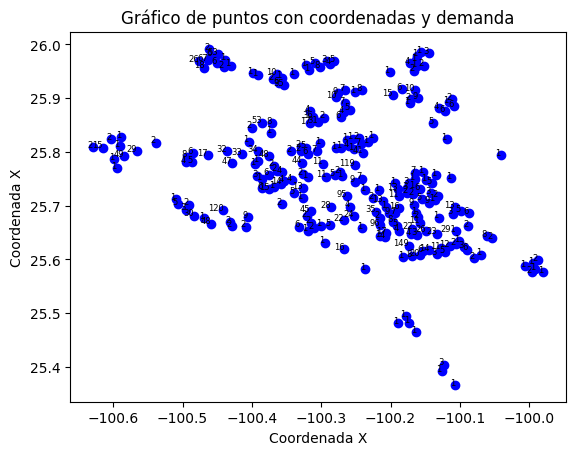

In [ ]:
#plt.figure(figsize=(8, 6))
plt.scatter(sublista_agrupado['coordenada_x'], sublista_agrupado['coordenada_y'], color='blue')

# Agregar etiquetas con el valor de demanda en cada punto
for i in range(len(sublista_agrupado)):
    plt.text(sublista_agrupado['coordenada_x'][i], sublista_agrupado['coordenada_y'][i],
             f"{sublista_agrupado['demanda'][i]:.0f}", fontsize=6, ha='right')

# Configurar los ejes
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada X')
plt.title('Gráfico de puntos con coordenadas y demanda')

In [ ]:
x_coords = [coord[0] for coord in df_estaciones['coordenadas']]
y_coords = [coord[1] for coord in df_estaciones['coordenadas']]

df_estaciones["coordenadas_x"] = x_coords
df_estaciones["coordenadas_y"] = y_coords


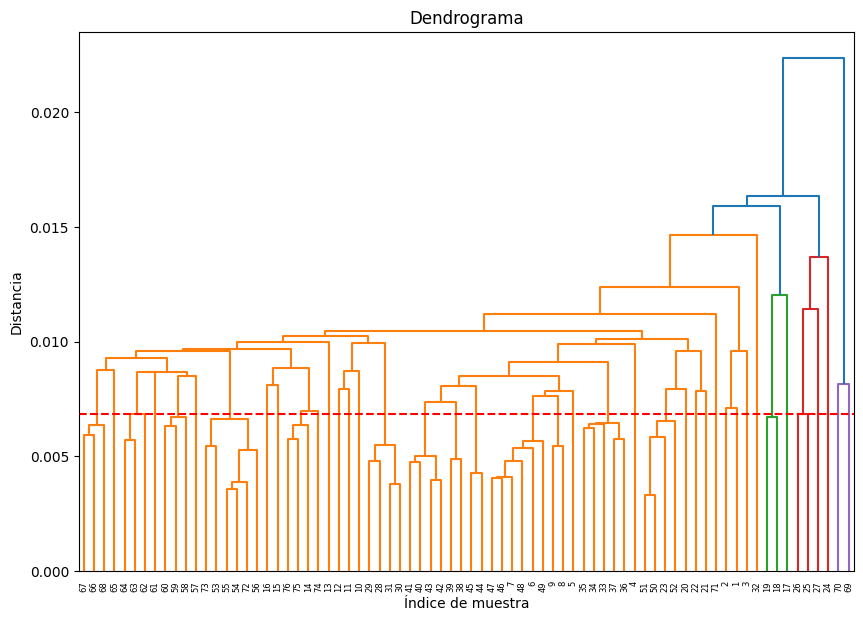

42


In [ ]:

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Selecciona las columnas de coordenadas para el clustering
X = df_estaciones[['coordenadas_x','coordenadas_y']]

# Calcular el enlace
linked = linkage(X, 'single')

# Crear el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', labels=np.arange(1, len(X)+1), distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrograma')
plt.xlabel('Índice de muestra')
plt.ylabel('Distancia')
#distancia_corte = 0.0075
plt.axhline(y=distancia_corte, color='r', linestyle='--')  # Línea de corte en la distancia 0.5
plt.show()



#distancia_corte = 0.06
clusters = fcluster(linked, distancia_corte, criterion='distance')
print(len(np.unique(clusters)))


In [ ]:
clusters

array([ 9, 10, 11, 23, 19, 18, 18, 17, 17, 27, 25, 26, 40, 28, 30, 31,  8,
        7,  7, 15, 12, 13, 14,  6,  3,  4,  5, 24, 24, 24, 24, 42, 16, 16,
       16, 16, 16, 21, 21, 22, 22, 22, 22, 20, 20, 18, 18, 18, 18, 14, 14,
       14, 32, 32, 32, 32, 34, 33, 33, 33, 37, 36, 35, 35, 39, 38, 38, 38,
        1,  2, 41, 32, 32, 29, 28, 28], dtype=int32)

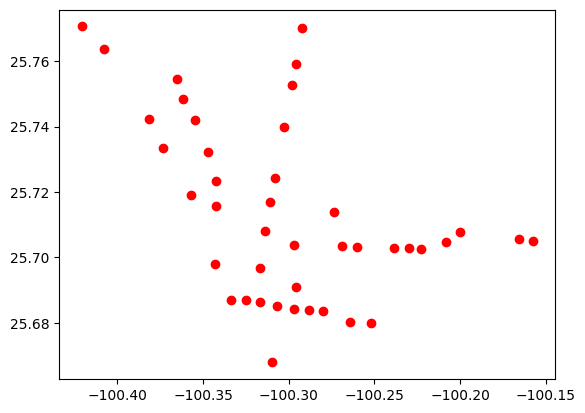

In [ ]:
df_estaciones['clasificación'] = clusters

estaciones_agrupado = df_estaciones.groupby('clasificación').agg(
    coordenada_x=('coordenadas_x', 'first'),  # Promediar los valores de 'coordenada_x'
    coordenada_y=('coordenadas_y', 'first')
).reset_index()

plt.scatter(estaciones_agrupado['coordenada_x'], estaciones_agrupado['coordenada_y'], color='red')

##Demanda por hora

In [ ]:
mask = df_estaciones['coordenadas'].isin([[-100.34390686, 25.69271623]])
active_customers = df_estaciones[mask]

print(active_customers["clasificación"].iloc[0] )

17


In [ ]:
df_estaciones.head()

,id,geometry,coordenadas,coordenadas_x,coordenadas_y,clasificación
0,estaciones_metro_ecovia.1,"{'type': 'Point', 'coordinates': [-100.3654740...","[-100.36547404, 25.7545747]",-100.365474,25.754575,9
1,estaciones_metro_ecovia.2,"{'type': 'Point', 'coordinates': [-100.3617501...","[-100.36175019, 25.74854753]",-100.361750,25.748548,10
2,estaciones_metro_ecovia.3,"{'type': 'Point', 'coordinates': [-100.3548425...","[-100.35484255, 25.74188396]",-100.354843,25.741884,11
3,estaciones_metro_ecovia.4,"{'type': 'Point', 'coordinates': [-100.3471946...","[-100.34719466, 25.73212953]",-100.347195,25.732130,23
4,estaciones_metro_ecovia.5,"{'type': 'Point', 'coordinates': [-100.3424304...","[-100.34243045, 25.72345902]",-100.342430,25.723459,19


In [ ]:

gdf['HoraOri_hour'] = gdf['HoraOri'].dt.hour

gdf['HoraDest_hour'] = gdf['HoraDest'].dt.hour


In [ ]:
# prompt: quitar los valores de gdf que en Nivel tenga estos valores valores_a_eliminar = ['A/B', 'C+','N/D']

valores_a_eliminar = ['A/B', 'C+', 'N/D']
gdf = gdf[~gdf['NIVEL'].isin(valores_a_eliminar)]

In [ ]:
# prompt: agrega una columna en gdf que sea llegada y que cheque el valor del coord_estacion_destino en esa fila y que lo busque en df_estaciones en coordenadas y ponga el valor que sale en la columna de clasificación

# Assuming you have a GeoDataFrame 'gdf' and a DataFrame 'df_estaciones' as defined in your code.
# Also, 'coord_estacion_destino' is a column in 'gdf' and 'coordenadas' is a column in 'df_estaciones'.

def find_llegada(row):
  """
  Finds the 'clasificación' value from df_estaciones based on the 'coord_estacion_destino' in the row.
  """
  coord_string = row['coord_estacion_destino']
  try:
    destino_coords = [float(x) for x in coord_string[1:-1].split(',')]
  except:
    destino_coords = []

  try:
    mask = df_estaciones['coordenadas'].isin([destino_coords])
    active_customers = df_estaciones[mask]
    if not active_customers.empty:
      #Always return a single value using .iloc[0]
      return active_customers["clasificación"].iloc[0]
    else:
      return None  # Or handle the case where no matching station is found
  except:
    return None

# Apply the function to create the 'llegada' column
gdf['llegada'] = gdf.apply(find_llegada, axis=1)

In [ ]:
gdf["llegada"].unique()

array([24, 17, 10,  5, 40, 28,  6, 32,  3, 12, 41, 31,  4, 25, 19,  9, 23,
        7, 26, 18, 13, 27, 29,  8, 15, 14, 11, 30], dtype=int32)

In [ ]:
# prompt: agrega una columna en gdf que sea clasificacion y que cheque el valor del ageb en esa fila y que lo busque en sublista_filtrada_socio y ponga el valor que sale en la columna de clasificación

# Assuming you have a GeoDataFrame 'gdf' and a DataFrame 'sublista_filtrada_socio'
# with 'AGEB' and 'clasificación' columns respectively.

def assign_classification(row):
  """
  Assigns classification based on AGEB value found in sublista_filtrada_socio.
  """
  ageb = row['AGEB']
  try:
    classification = sublista_filtrada_socio.loc[sublista_filtrada_socio['AGEB'] == ageb, 'clasificación'].iloc[0]
    return classification
  except IndexError:
    return None  # Or handle missing values appropriately


# Apply the function to create a new column 'clasificación' in 'gdf'.
gdf['clasificación'] = gdf.apply(assign_classification, axis=1)


In [ ]:
# prompt: separa gdf en un dataframe para cada hora de las 6 a las 12 segun el valor de la columna HoraOri_hour

# Crear una lista para almacenar los DataFrames de cada hora
dfs_por_hora = []

# Iterar sobre las horas de 6 a 12
for hora in range(6, 13):
  # Filtrar el GeoDataFrame por la hora actual
  gdf_hora = gdf[gdf['HoraOri_hour'] == hora]
  # Agregar el DataFrame a la lista
  dfs_por_hora.append(gdf_hora)

# Ahora tienes una lista de DataFrames, uno para cada hora.
# Puedes acceder a ellos usando dfs_por_hora[0] para la hora 6, dfs_por_hora[1] para la hora 7, etc.

In [ ]:
# Crear una lista para almacenar los DataFrames de cada hora
dfs_por_hora_metro = []

# Iterar sobre las horas de 6 a 12
for hora in range(6, 13):
  # Filtrar el GeoDataFrame por la hora actual
  gdf_hora_2 = gdf[gdf['HoraDest_hour'] == hora]
  # Agregar el DataFrame a la lista
  dfs_por_hora_metro.append(gdf_hora)

In [ ]:
lugares_unicos = list(range(1, 45))  # Lista de 261 lugares (1 a 261)
resultados_por_hora_metro = []

for df_hora in dfs_por_hora_metro:
  resultados_lugar = []
  for lugar in lugares_unicos:
    suma_clasificacion_1 = df_hora[(df_hora['llegada'] == lugar)].shape[0]
    resultados_lugar.append(suma_clasificacion_1)
  resultados_por_hora_metro.append(resultados_lugar)

In [ ]:
# prompt: para cada dataframe de dfs_por_hora hacer una lista de 261 lugares y para cada lugar de la lista sumar las filas que tengan clasificación igual a 1 más del lugar de la lista

lugares_unicos = list(range(1, 263))  # Lista de 261 lugares (1 a 261)
resultados_por_hora = []

for df_hora in dfs_por_hora:
  resultados_lugar = []
  for lugar in lugares_unicos:
    suma_clasificacion_1 = df_hora[(df_hora['clasificación'] == lugar)].shape[0]
    resultados_lugar.append(suma_clasificacion_1)
  resultados_por_hora.append(resultados_lugar)

# resultados_por_hora ahora contiene una lista de listas, donde cada lista interna representa
# la suma de filas con clasificación 1 para cada lugar en cada DataFrame de dfs_por_hora.

In [ ]:
len(paradas)

17

In [ ]:
len(estaciones_agrupado)

42

In [ ]:
# prompt: a cada lista de resultados_por_hora agregar la lista correspondiente en  resultados_por_hora_metro al principio

# resultados_por_hora ahora contiene una lista de listas, donde cada lista interna representa
# la suma de filas con clasificación 1 para cada lugar en cada DataFrame de dfs_por_hora.
# Iterar sobre las listas de resultados_por_hora y agregar la lista correspondiente
# de resultados_por_hora_metro al principio de cada lista.
for i in range(len(resultados_por_hora)):
  resultados_por_hora[i] = resultados_por_hora_metro[i] + resultados_por_hora[i]

In [ ]:
len(resultados_por_hora[1])

306

##Unir Datos

In [ ]:
# prompt: agrega los dos puntos generados a sublista_filtrada en los primeros dos valores

import pandas as pd
# Create a GeoDataFrame for the new points
from shapely.geometry import Point

# Concatenate the new points to the beginning of sublista_filtrada
sublista_filtrada_con_puntos = pd.concat([estaciones_agrupado, sublista_agrupado], ignore_index=True)




In [ ]:
sublista_agrupado.shape

(248, 4)

In [ ]:
estaciones_agrupado.shape

(42, 3)

In [ ]:
df_matriz_traslados_6 = pd.read_csv('matriz_traslados_6.csv', index_col=0)
df_matriz_traslados_7 = pd.read_csv('matriz_traslados_7.csv', index_col=0)
df_matriz_traslados_8 = pd.read_csv('matriz_traslados_8.csv', index_col=0)
df_matriz_traslados_9 = pd.read_csv('matriz_traslados_9.csv', index_col=0)
df_matriz_traslados_10 = pd.read_csv('matriz_traslados_10.csv', index_col=0)
df_matriz_traslados_11 = pd.read_csv('matriz_traslados_11.csv', index_col=0)
df_matriz_traslados_12 = pd.read_csv('matriz_traslados_12.csv', index_col=0)



In [ ]:
df_matriz_traslados = [df_matriz_traslados_6,df_matriz_traslados_7,df_matriz_traslados_8,df_matriz_traslados_9,
                       df_matriz_traslados_10,df_matriz_traslados_11,df_matriz_traslados_12]
tabla_tiempos = [6,7,8,9,10,11,12]

#Corrida de Codigo

In [ ]:
sublista_filtrada_con_puntos

,clasificación,coordenada_x,coordenada_y,demanda
0,1,-100.165675,25.705563,NaN
1,2,-100.157548,25.705007,NaN
2,3,-100.297897,25.752645,NaN
3,4,-100.295570,25.759090,NaN
4,5,-100.292499,25.770103,NaN
...,...,...,...,...
285,244,-100.112218,25.750709,1.0
286,245,-100.266801,25.618600,16.0
287,246,-100.295161,25.630942,1.0
288,247,-100.236883,25.581457,1.0


In [ ]:
sublista_filtrada_con_puntos_antes = pd.read_csv('sublista_filtrada_con_puntos.csv')

In [ ]:
sublista_filtrada_con_puntos_antes

,clasificación,coordenada_x,coordenada_y,demanda
0,1,-100.165675,25.705563,10
1,1,-100.157548,25.705007,10
2,1,-100.297897,25.752645,10
3,1,-100.295570,25.759090,10
4,1,-100.292499,25.770103,10
...,...,...,...,...
285,2,-100.265421,25.618422,33
286,2,-100.295161,25.630942,4
287,2,-100.288776,25.633278,1
288,2,-100.236883,25.581457,1


In [ ]:
# prompt: haz una lista que sea la columna de suma de sublista_filtrada_con_puntos

demanda = resultados_por_hora


In [ ]:
len(estaciones_agrupado)

42

In [ ]:
cantidad_estaciones = len(estaciones_agrupado)
cantidad_paradas = len(sublista_agrupado)
cantidad_nodos = len(sublista_filtrada_con_puntos)
cantidad_autobuses = 30

metro = list(range(cantidad_estaciones))  # Subway stations
paradas = list(range(cantidad_estaciones, cantidad_nodos)) # Bus stops
autobuses = list(range(cantidad_autobuses)) # Feeder routes
nodos = metro + paradas # Nodes (bus stops + subway stations)

num_metro = len(metro)
num_paradas = len(paradas)
num_autobuses = len(autobuses)
num_nodos = len(nodos)

In [ ]:
times = df_matriz_traslados
import numpy as np
times = np.array(times)

In [ ]:
#num_iteration=200
num_iteration=200

In [ ]:
tiempo_duración = 540/3

In [ ]:
times.shape

(7, 290, 290)

In [ ]:
# prompt: dividir cada valor de times entre 60 cast rule "same_kind"

# Assuming 'times' is a NumPy array containing travel times.
# Divide each value in 'times' by 60 and cast the result to the same data type as 'times'.
times_divided = np.array(times, dtype=np.float64) / (60)
times = np.array(times_divided, dtype=times.dtype)


In [ ]:
len(sublista_filtrada_con_puntos)

290

In [ ]:
len(nodos)

290

In [ ]:
Q=300

In [ ]:
demanda = resultados_por_hora

In [ ]:
best_list=[]
best_obj=[]
best_list,best_obj = todo_9_2()

[[[np.int64(64), 157, 267, 136, 235, 132, 31], [np.int64(47), 39, 218, 164, 286, 143], [np.int64(189), 190, 134, 235, 236, 288], [np.int64(65), 52, 11, 201], [np.int64(259), 179, 89, 195, 270], [np.int64(2), 273, 163, 16, 0, 114], [np.int64(162), 191, 206, 221, 217, 205, 2, 43], [np.int64(68), 36, 146, 87, 164], [np.int64(100), 53, 107, 156, 72, 175], [np.int64(124), 35, 272, 43, 260, 104], [np.int64(278), 91, 56, 81], [np.int64(10), 114, 254, 158, 166, 21], [np.int64(92), 107, 113, 218], [np.int64(5), 236, 150, 90, 55], [np.int64(233), 288, 224, 141, 61], [np.int64(105), 149, 134, 208, 156], [np.int64(106), 158, 204, 210, 206, 227, 110, 180], [np.int64(84), 279, 259, 11, 132, 181], [np.int64(108), 289, 220, 235, 107], [np.int64(51), 187, 176, 30, 161, 267], [np.int64(166), 71, 282, 137, 270], [np.int64(40), 264, 156, 221, 94], [np.int64(78), 134, 176, 192, 227, 149], [np.int64(172), 217, 237, 181, 191, 108, 226], [np.int64(183), 143, 65, 126, 240], [np.int64(217), 32, 139, 155, 122, 1

KeyboardInterrupt: 

In [ ]:
# prompt: plot las rutas que estan en best_list[0] usando los puntos que estan en la sublista_filtrada_con_puntos

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

# Plotea el GeoDataFrame con la columna 'suma' como valores de color
plt.scatter(sublista_filtrada_con_puntos['coordenada_x'], sublista_filtrada_con_puntos['coordenada_y'], color='red')

# Agrega las rutas al plot
for i, ruta in enumerate(best_list[0]):
  color = plt.cm.get_cmap('tab10')(i / len(best_list[0]))  # Get a different color for each route
  x_coords = [sublista_filtrada_con_puntos.loc[nodo, 'coordenada_x'] for nodo in ruta]
  y_coords = [sublista_filtrada_con_puntos.loc[nodo, 'coordenada_y']  for nodo in ruta]
  plt.plot(x_coords, y_coords, marker='o', color=color, label=f'Ruta {i+1}')

plt.title('Rutas de autobuses en Monterrey')
plt.legend()
plt.show()


In [ ]:
best_list=[]
best_obj=[]
best_list,best_obj = todo_9()

TypeError: list.extend() takes exactly one argument (2 given)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

# Plotea el GeoDataFrame con la columna 'suma' como valores de color
plt.scatter(sublista_filtrada_con_puntos['coordenada_x'], sublista_filtrada_con_puntos['coordenada_y'], color='red')

# Agrega las rutas al plot
for i, ruta in enumerate(best_list[0]):
  color = plt.cm.get_cmap('tab10')(i / len(best_list[0]))  # Get a different color for each route
  x_coords = [sublista_filtrada_con_puntos.loc[nodo, 'coordenada_x'] for nodo in ruta]
  y_coords = [sublista_filtrada_con_puntos.loc[nodo, 'coordenada_y']  for nodo in ruta]
  plt.plot(x_coords, y_coords, marker='o', color=color, label=f'Ruta {i+1}')

plt.title('Rutas de autobuses en Monterrey')
plt.legend()
plt.show()


In [ ]:
# prompt: times to matrix

import numpy as np
times = np.array(times)


heuristico_dt= np.zeros_like(times)
for k in range(times):
  for i in range(times[k].shape[0]):
    for j in range(times[k].shape[1]):
      if times[k][i][j] != 0:
        heuristico_dt[k][i][j] = demanda[k][j]/times[k][i][j]

In [ ]:
best_list=[]
best_obj=[]
best_list,best_obj = todo2()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

# Plotea el GeoDataFrame con la columna 'suma' como valores de color
plt.scatter(sublista_filtrada_con_puntos['coordenada_x'], sublista_filtrada_con_puntos['coordenada_y'], color='red')

# Agrega las rutas al plot
for i, ruta in enumerate(best_list[0]):
  color = plt.cm.get_cmap('tab10')(i / len(best_list[0]))  # Get a different color for each route
  x_coords = [sublista_filtrada_con_puntos.loc[nodo, 'coordenada_x'] for nodo in ruta]
  y_coords = [sublista_filtrada_con_puntos.loc[nodo, 'coordenada_y']  for nodo in ruta]
  plt.plot(x_coords, y_coords, marker='o', color=color, label=f'Ruta {i+1}')

plt.title('Rutas de autobuses en Monterrey')
plt.legend()
plt.show()
